In [2]:
# conda install -c conda-forge catboost

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ndcg_score, make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.stats import randint as sp_randint

In [4]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
random_seed = 1106
set_random_seed(random_seed)

In [5]:
train = pd.read_csv('train_users_2.csv')
session = pd.read_csv('sessions.csv')

## Train 전처리

In [6]:
# train 전처리
train.rename(columns={'id':'user_id'},inplace=True)
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S')
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

In [7]:
train.isnull().sum()

user_id                         0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [8]:
train_user_ids = set(train['user_id'])
session_user_ids = set(session['user_id'])
# session 데이터에서 train 데이터에 존재하는 user_id만 필터링하여 사용
merged_session = session[session['user_id'].isin(train_user_ids)]
merged_session.isnull().sum()

merged_train = train[train['user_id'].isin(session_user_ids)]

### age -> age group으로 대체
- 18세 이하는 가입이 불가능하니 해당되는 나이는 0으로 대체
- 결측치는 1로 대체 
- 1000이상인 값은 2
- 1000미만 100세 초과는 3
- 18~100세 사이 4

In [9]:
merged_train.isnull().sum()

user_id                        0
date_account_created           0
timestamp_first_active         0
date_first_booking         45041
gender                         0
age                        32248
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [10]:
import numpy as np

# 나이 그룹을 계산하는 함수 정의
def calculate_age_group(age):
    if np.isnan(age):
        return 1
    elif age < 18:
        return 0
    elif age >= 1000:
        return 2
    elif age > 100:
        return 3
    return 4

# apply 함수를 사용하여 age_group 계산

merged_train = merged_train.copy()
merged_train['age_group'] = merged_train['age'].apply(calculate_age_group)

merged_train['age_group'].value_counts()

age_group
4    40795
1    32248
3      590
2      131
0       51
Name: count, dtype: int64

## 결측치 처리

In [11]:
merged_train.isnull().sum()

user_id                        0
date_account_created           0
timestamp_first_active         0
date_first_booking         45041
gender                         0
age                        32248
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked      302
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
age_group                      0
dtype: int64

In [12]:
if 'age' in merged_train.columns:
    merged_train.drop(columns=['age'], inplace=True)
merged_train.loc[:, 'first_affiliate_tracked'].fillna('untracked', inplace=True)


## Session 전처리

In [13]:
merged_session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [14]:
merged_session.isnull().sum()

user_id               0
action            51532
action_type      619860
action_detail    619860
device_type           0
secs_elapsed      73815
dtype: int64

In [15]:
merged_session=merged_session.copy()
merged_session['action'].replace('-unknown-', 'unknown', inplace=True)
merged_session['action_type'].replace('-unknown-', 'unknown', inplace=True)
merged_session['action_detail'].replace('-unknown-', 'unknown', inplace=True)
merged_session['device_type'].replace('-unknown-', 'unknown', inplace=True)

In [16]:
merged_session['action'].fillna('unknown', inplace=True)
merged_session['action_type'].fillna('unknown', inplace=True)
merged_session['action_detail'].fillna('unknown', inplace=True)

In [17]:
merged_session['secs_elapsed'].fillna(0, inplace=True)

In [18]:
# user_flow 컬럼 생성

merged_session['user_flow'] = merged_session['action'].astype('str') + '+' + merged_session['action_type'].astype('str') + '+' + merged_session['action_detail'].astype('str')

In [19]:
merged_session.isnull().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
user_flow        0
dtype: int64

### action columns

- action+type+detail = user_flow로 묶고 user_id 별 모든 user_flow를 한 string으로 합치기
- train과 머지했을 때 중복을 피하기 위함
- 구분자는 쉼표

In [20]:
user_flows_concatenated = merged_session.groupby('user_id')['user_flow'].apply(lambda x: ','.join(x)).reset_index()

merged_session = pd.merge(merged_session.drop(columns=['user_flow']), user_flows_concatenated, on='user_id', how='left')

In [21]:
merged_session

,user_id,action,action_type,action_detail,device_type,secs_elapsed,user_flow
0,d1mm9tcy42,lookup,unknown,unknown,Windows Desktop,319.0,"lookup+unknown+unknown,search_results+click+vi..."
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,"lookup+unknown+unknown,search_results+click+vi..."
2,d1mm9tcy42,lookup,unknown,unknown,Windows Desktop,301.0,"lookup+unknown+unknown,search_results+click+vi..."
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,"lookup+unknown+unknown,search_results+click+vi..."
4,d1mm9tcy42,lookup,unknown,unknown,Windows Desktop,435.0,"lookup+unknown+unknown,search_results+click+vi..."
...,...,...,...,...,...,...,...
5537952,nw9fwlyb5f,index,data,reservations,iPhone,245.0,"show+view+user_profile,show+view+p3,reviews+da..."
5537953,nw9fwlyb5f,unavailabilities,data,unavailable_dates,iPhone,286.0,"show+view+user_profile,show+view+p3,reviews+da..."
5537954,nw9fwlyb5f,notifications,submit,notifications,iPhone,830.0,"show+view+user_profile,show+view+p3,reviews+da..."
5537955,nw9fwlyb5f,search,click,view_search_results,iPhone,101961.0,"show+view+user_profile,show+view+p3,reviews+da..."


In [22]:
session_df = merged_session.copy()

### feature engineering
- user_id별 평균 세션 시간 생성
- user_id별 가장 많이 쓴 주요 device_type 생성
- user_id별 세션 총 개수 생성

In [23]:
# user_id별 평균 secs_elapsed column 생성
session_df['mean_secs_elapsed'] = session_df.groupby('user_id')['secs_elapsed'].transform('mean')
# user_id별 가장 빈도수가 높은 device_type column 생성
session_df['most_frequent_device'] = session_df.groupby('user_id')['device_type'].transform(lambda x: x.mode()[0])
# user_id별 세션 총 개수
session_df['session_count'] = session_df.groupby('user_id')['action'].transform('count')

In [24]:
len(session_df['user_id'].unique())

73815

In [25]:
session_df2 = session_df.copy()

In [26]:
session_df2.drop(['action', 'action_type', 'action_detail', 'device_type', 'secs_elapsed'], axis=1, inplace=True)

In [27]:
session_df2.drop_duplicates(subset='user_id', inplace=True)

In [28]:
session_df2

,user_id,user_flow,mean_secs_elapsed,most_frequent_device,session_count
0,d1mm9tcy42,"lookup+unknown+unknown,search_results+click+vi...",26988.417323,Windows Desktop,127
127,yo8nz8bqcq,"dashboard+view+dashboard,create+submit+create_...",23093.555556,Mac Desktop,9
136,4grx6yxeby,"verify+unknown+unknown,create+submit+create_us...",70965.250000,Windows Desktop,16
152,ncf87guaf0,"lookup+unknown+unknown,show+view+p3,search_res...",24704.605263,Windows Desktop,152
304,4rvqpxoh3h,"campaigns+unknown+unknown,active+unknown+unkno...",319.375000,iPhone,8
...,...,...,...,...,...
5537475,zxodksqpep,"edit+view+edit_profile,edit+view+edit_profile,...",46739.963636,Mac Desktop,110
5537585,mhewnxesx9,"confirm_email+click+confirm_email_link,dashboa...",12096.319328,Windows Desktop,238
5537823,6o3arsjbb4,ajax_refresh_subtotal+click+change_trip_charac...,19054.555556,Mac Desktop,18
5537841,jh95kwisub,"search+click+view_search_results,search+click+...",4554.786667,iPhone,75


## train, session merge

In [29]:
merged_df = pd.merge(merged_train, session_df2, on='user_id', how='inner')

In [30]:
merged_df

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_group,user_flow,mean_secs_elapsed,most_frequent_device,session_count
0,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,4,"lookup+unknown+unknown,search_results+click+vi...",26988.417323,Windows Desktop,127
1,yo8nz8bqcq,2014-01-01,2014-01-01 00:15:58,NaT,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,1,"dashboard+view+dashboard,create+submit+create_...",23093.555556,Mac Desktop,9
2,4grx6yxeby,2014-01-01,2014-01-01 00:16:39,NaT,-unknown-,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,1,"verify+unknown+unknown,create+submit+create_us...",70965.250000,Windows Desktop,16
3,ncf87guaf0,2014-01-01,2014-01-01 00:21:46,NaT,-unknown-,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,1,"lookup+unknown+unknown,show+view+p3,search_res...",24704.605263,Windows Desktop,152
4,4rvqpxoh3h,2014-01-01,2014-01-01 00:26:19,2014-01-02,-unknown-,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,1,"campaigns+unknown+unknown,active+unknown+unkno...",319.375000,iPhone,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73810,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,4,"edit+view+edit_profile,edit+view+edit_profile,...",46739.963636,Mac Desktop,110
73811,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,1,"confirm_email+click+confirm_email_link,dashboa...",12096.319328,Windows Desktop,238
73812,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,4,ajax_refresh_subtotal+click+change_trip_charac...,19054.555556,Mac Desktop,18
73813,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,1,"search+click+view_search_results,search+click+...",4554.786667,iPhone,75


# Modeling

In [31]:
# NDCG metric 이용하여 확인
X = merged_df.drop(['user_id', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df['country_destination']

cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'user_flow',
                'most_frequent_device']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = CatBoostClassifier(iterations=10, 
                            learning_rate=0.1, 
                            depth=6, 
                            loss_function='MultiClass',
                            cat_features=cat_features,
                            random_seed=random_seed)

model.fit(X_train, y_train)

# 각 나라에 대해서 확률 값을 나타냄 
y_pred_probs = model.predict_proba(X_test)

# 가장 높은 확률 5개의 index를 추출
top_5_indices = np.argsort(y_pred_probs, axis=1)[:, ::-1][:, :5]

# 모델에서 사용한 카테고리 목록
classes = model.classes_

# 순서대로 예측한 나라 목록
top_5_classes = np.array(classes)[top_5_indices]

# airbnb식 평가 지표 - 이론적인 ndcg와 다름(relevance값이 binary이므로 정답 나라의 위치만 중요, 나머지는 계산 x)
# 또한 iDCG의 경우도 정답 나라가 1순위에 오는 것이 이상적이므로 항상 1의 값을 가짐.
# 그렇다면 n개의 예측을 평가 지표로써 사용하기 위해 각 ndcg값을 더한 후 n개로 나눠주어 점수 계산

def calculate_ndcg(predicted_answers, true_answers):
    ndcg=0
    for predicted, true in zip(predicted_answers, true_answers):
        relevance = [1 if ans == true else 0 for ans in predicted]
        dcg = np.sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevance)])
        ndcg += dcg
    return ndcg/len(true_answers)


ndcg = calculate_ndcg(top_5_classes, y_test)
print("NDCG:", ndcg)


0:	learn: 1.9974052	total: 677ms	remaining: 6.09s
1:	learn: 1.7784876	total: 1.28s	remaining: 5.14s
2:	learn: 1.6321244	total: 1.75s	remaining: 4.08s
3:	learn: 1.5245332	total: 2.1s	remaining: 3.16s
4:	learn: 1.4419220	total: 2.37s	remaining: 2.37s
5:	learn: 1.3730978	total: 3.07s	remaining: 2.05s
6:	learn: 1.3186638	total: 3.7s	remaining: 1.58s
7:	learn: 1.2732544	total: 4.31s	remaining: 1.08s
8:	learn: 1.2352120	total: 4.76s	remaining: 529ms
9:	learn: 1.2037915	total: 5.02s	remaining: 0us
NDCG: 0.8332023582459728


In [32]:
for i in top_5_classes:
    print(i)

['US' 'NDF' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['US' 'NDF' 'other' 'FR' 'IT']
['NDF' 'US' 'other' 'FR' 'IT']
['NDF' '

In [33]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

/var/folders/zf/6h5l4dc57cj2qkp7wv1dz7zr0000gn/T/ipykernel_11859/2883097090.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


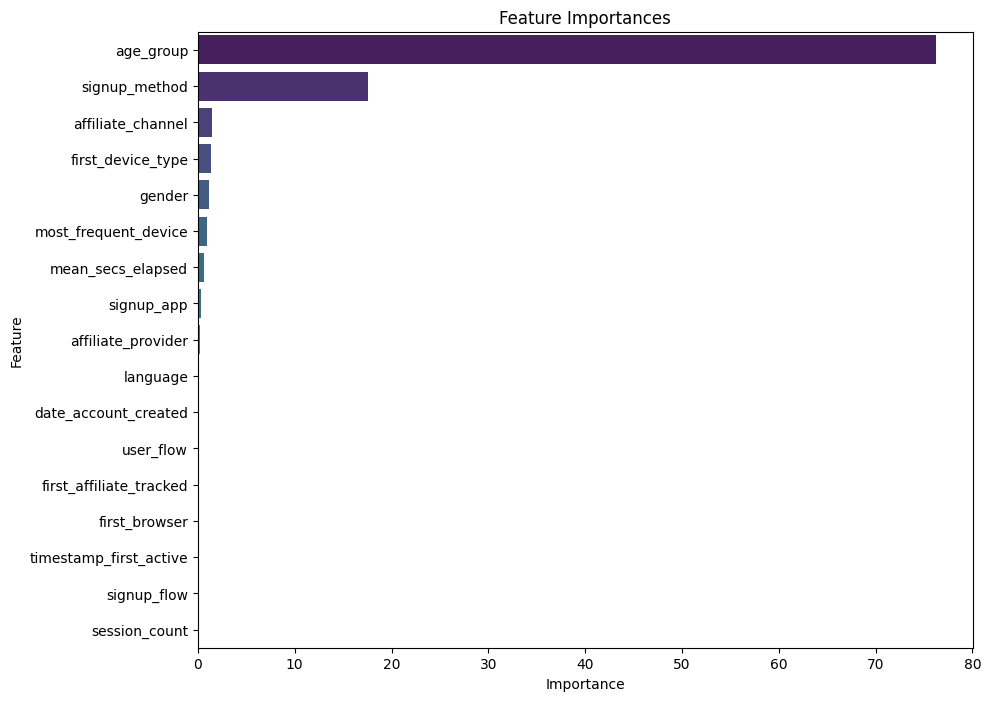

In [34]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [43]:
y_test.index

Index([67792, 10047,  5083, 69000, 54931, 68077, 70478, 65758, 52195, 39041,
       ...
       42927,  3774, 26419, 44704,  3280, 38725, 25776, 65988, 68829, 65596],
      dtype='int64', length=14763)

In [45]:
merged_df

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_group,user_flow,mean_secs_elapsed,most_frequent_device,session_count
0,d1mm9tcy42,2014-01-01,2014-01-01 00:09:36,2014-01-04,MALE,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,4,"lookup+unknown+unknown,search_results+click+vi...",26988.417323,Windows Desktop,127
1,yo8nz8bqcq,2014-01-01,2014-01-01 00:15:58,NaT,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,1,"dashboard+view+dashboard,create+submit+create_...",23093.555556,Mac Desktop,9
2,4grx6yxeby,2014-01-01,2014-01-01 00:16:39,NaT,-unknown-,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,1,"verify+unknown+unknown,create+submit+create_us...",70965.250000,Windows Desktop,16
3,ncf87guaf0,2014-01-01,2014-01-01 00:21:46,NaT,-unknown-,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,1,"lookup+unknown+unknown,show+view+p3,search_res...",24704.605263,Windows Desktop,152
4,4rvqpxoh3h,2014-01-01,2014-01-01 00:26:19,2014-01-02,-unknown-,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,1,"campaigns+unknown+unknown,active+unknown+unkno...",319.375000,iPhone,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73810,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,4,"edit+view+edit_profile,edit+view+edit_profile,...",46739.963636,Mac Desktop,110
73811,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,1,"confirm_email+click+confirm_email_link,dashboa...",12096.319328,Windows Desktop,238
73812,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,4,ajax_refresh_subtotal+click+change_trip_charac...,19054.555556,Mac Desktop,18
73813,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,1,"search+click+view_search_results,search+click+...",4554.786667,iPhone,75


In [50]:
# y_test.index에 해당하는 유저 ID와 예측된 나라들을 추출
user_ids = merged_df.loc[y_test.index, 'user_id']

# 데이터프레임으로 변환하여 출력
output_data = []
for user_id, countries in zip(user_ids, top_5_classes):
    for country in countries:
        output_data.append({'id': user_id, 'country': country})

output_df = pd.DataFrame(output_data)
print(output_df)

               id country
0      ro4nee3256      US
1      ro4nee3256     NDF
2      ro4nee3256   other
3      ro4nee3256      FR
4      ro4nee3256      IT
...           ...     ...
73810  suj80z2yqc     NDF
73811  suj80z2yqc      US
73812  suj80z2yqc   other
73813  suj80z2yqc      FR
73814  suj80z2yqc      IT

[73815 rows x 2 columns]


In [36]:
merged_df2 = merged_df.copy()

In [37]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df2['user_flow'])

# TF-IDF를 기존 데이터프레임에 추가
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
merged_df_with_tfidf = pd.concat([merged_df2, tfidf_df], axis=1)

# TF-IDF를 적용한 데이터에서 불필요한 열 제거
merged_df_with_tfidf.drop(['user_flow'], axis=1, inplace=True)

In [38]:
X = merged_df_with_tfidf.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
                'most_frequent_device']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = CatBoostClassifier(iterations=100, 
                            learning_rate=0.1, 
                            depth=6, 
                            loss_function='MultiClass',
                            cat_features=cat_features,
                            random_seed=random_seed)

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)

ndcg = ndcg_score(lb.transform(y_test), y_pred_probs)

print("NDCG Score:", ndcg)

0:	learn: 1.9651377	test: 1.9708213	best: 1.9708213 (0)	total: 898ms	remaining: 1m 28s
20:	learn: 0.9739293	test: 0.9965412	best: 0.9965412 (20)	total: 18.7s	remaining: 1m 10s
40:	learn: 0.9240249	test: 0.9535432	best: 0.9535432 (40)	total: 39.8s	remaining: 57.3s
60:	learn: 0.9128514	test: 0.9462666	best: 0.9462666 (60)	total: 1m 1s	remaining: 39.6s
80:	learn: 0.9050738	test: 0.9424381	best: 0.9424381 (80)	total: 1m 28s	remaining: 20.8s
99:	learn: 0.8996541	test: 0.9407186	best: 0.9407186 (99)	total: 1m 49s	remaining: 0us

bestTest = 0.9407186333
bestIteration = 99

NDCG Score: 0.8634070056916552


In [39]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[:15]

,Feature,Importance
10,age_group,27.686938
79,booking_request,20.706266
0,gender,3.406094
70,ask_question,2.931756
1,signup_method,2.451020
4,affiliate_channel,2.377454
227,message_post,2.018484
8,first_device_type,1.994436
117,create,1.324825
107,confirm_email,1.309363


In [40]:
# 예측된 상위 5개의 나라 확인
top5_pred_indices = np.argsort(y_pred_probs, axis=1)[:, ::-1][:, :5]

# Convert top 5 indices to country labels
top5_pred_countries = model.classes_[top5_pred_indices]

print("Top 5 Predicted Countries:")
print(top5_pred_countries)

Top 5 Predicted Countries:
[['US' 'NDF' 'other' 'FR' 'IT']
 ['US' 'NDF' 'other' 'FR' 'IT']
 ['NDF' 'US' 'other' 'FR' 'IT']
 ...
 ['NDF' 'US' 'other' 'FR' 'IT']
 ['NDF' 'US' 'other' 'FR' 'IT']
 ['NDF' 'US' 'other' 'FR' 'IT']]


In [41]:
# RandomizedSearch에 사용하기 위해 커스텀 ndcg scorer 생성 -> 아직 사용 안함
def ndcg_scorer(y_true, y_pred_proba):
    ndcg = ndcg_score(y_true, y_pred_proba)
    return ndcg

In [42]:
# iterations 200, lr 0.1로 시도
# 하지만 이건 타깃 클래스의 밸런스를 고려하지 않은 것
X = merged_df_with_tfidf.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
                'most_frequent_device']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = CatBoostClassifier(iterations=200, 
                            learning_rate=0.1, 
                            depth=6, 
                            loss_function='MultiClass',
                            cat_features=cat_features,
                            random_seed=random_seed)

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=40)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

ndcg = ndcg_score(y_test_bin, y_pred_probs)

print("NDCG Score:", ndcg)

0:	learn: 1.9632574	test: 1.9686923	best: 1.9686923 (0)	total: 1.25s	remaining: 4m 8s


KeyboardInterrupt: 

In [ ]:
# StratifiedKFold 사용
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=cat_features,
                           random_seed=random_seed,
                           verbose=40)

ndcg_scores = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(lb.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

In [ ]:
cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
                'most_frequent_device']

In [ ]:
X = merged_df_with_tfidf.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df_with_tfidf['country_destination']

In [ ]:
# feature 그대로, iterations만 다르게 진행
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=200, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=cat_features,
                           random_seed=random_seed,
                           verbose=40)

ndcg_scores = []

lb = LabelBinarizer()
lb.fit(y)

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(lb.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

In [ ]:
feature_importances = model.feature_importances_

features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
importance_df

In [ ]:
# 중요도가 낮은 피처들 제거
low_importance_feat = importance_df[importance_df['Importance'] < 0.01]['Feature'].to_list()
# low_importance_feat

In [ ]:
len(low_importance_feat)

### feature 제거
- 중요도가 0.01보다 낮은 피처를 제거하고 다시 시도

In [ ]:
cat_features2 = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type',
                'most_frequent_device']

In [ ]:
cols_to_drop = ['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination']
combined_list = cols_to_drop + low_importance_feat

X2 = merged_df_with_tfidf.drop(combined_list, axis=1)
y2 = merged_df_with_tfidf['country_destination']

In [ ]:
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=200, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=cat_features2,
                           random_seed=random_seed,
                           verbose=40)

ndcg_scores = []

lb = LabelBinarizer()
lb.fit(y2)

for train_index, test_index in skf.split(X2, y2):
    X_train_fold, X_test_fold = X2.iloc[train_index], X2.iloc[test_index]
    y_train_fold, y_test_fold = y2.iloc[train_index], y2.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(lb.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

In [ ]:
멀티 클래스 평가지표 -> catboost mdcg(k=5)